# Simplicity in unsupervised categorisation

In [1]:
import numpy as np
from math import factorial, comb, inf, log2, ceil, pow
import matplotlib.pyplot as plt

### Implementing the formalisation

In [2]:
def compute_pairwise_distances(points:list[list[int]]) -> np.array:
    """
    Compute the distance between every pair of points
    
    Args:
        points (list[list[int]]): a list of coordinates of points, each inner list contains two values: 
                                 coordinate x and coordinate y
    
    Returns: 
        np.array: a matrix that contains all pairwise distances between points
    
    """
    points_matrix = np.repeat(points, len(points), axis=0).reshape(len(points),len(points),2)
    points_matrix_T = np.concatenate([points]*len(points), axis=0).reshape(len(points),len(points),2)
  
    return np.linalg.norm(points_matrix_T-points_matrix, axis=2)

In [3]:
def compute_constraints(categories:list[list[int]]) -> int:
    """
    Compute the constraints: distance two points within same cluster < distance two points between two different clusters
    
    Args:
        categories(list[list[int]]): a list of categories of points, each inner list contains two values: 
                                    coordinate x and coordinate y
    
    Returns: 
        int: the distance between two points in the same category multiplied with the distance between two points in different 
        categories
    
    """
    inside_dists = 0
    for c in categories:
        inside_dists += (len(c)*(len(c)-1))/2

    ouside_dists = 0
    for i in range(len(categories)-1):
        for j in range(i+1, len(categories)):
            ouside_dists += len(categories[i])*len(categories[j])

    return inside_dists * ouside_dists


In [4]:
def compute_categorisation_costs(points:list[list[int]], categories:list[list[int]]) -> int: 
    """
    Compute the cost of making a partition of the categorization
    
    Args:
        points (list[list[int]]): a list of coordinates of points, each inner list contains two values: 
                                 coordinate x and coordinate y
        categories(list[list[int]]): a list of categories of points, each inner list contains two values: 
                                    coordinate x and coordinate y
    
    Returns: 
        int: the cost of making a partition
    
    """
    r = len(points)
    n = len(categories)
    part_r_n = sum((pow(-1, v)) * (pow(n-v, r)) / (factorial(n-v)*factorial(v)) for v in range(n))  # Stirling number of 2nd kind
    
    return ceil(log2(len(categories)+1)) + ceil(log2(part_r_n))

In [5]:
def compute_number_of_errors(points, categories):
    """
    Compute the number of errors in a certain partition
    
    Args:
        points: the points of the partition
        categories: the categories in which the points are divided for this particular partition
    
    Returns: 
        int: amount of errors made
    
    """
    error_counter = 0
    distance_matrix = compute_pairwise_distances(points)

    ij_in_same_category = False        
    kl_in_same_category = False

    # Iterate over top right part of distance matrix, current points are (i,j)
    for i in range(0, distance_matrix.shape[0]):
        for j in range(i+1, distance_matrix.shape[1]):
            # d(i,j) is the fist distance
            # Check if i and j are in the same or in different categories
            for c in categories:  
                if (i in c) and not(j in c) or not(i in c) and (j in c): # i and j in different categories
                    ij_in_same_category = False
                    break  
                if i in c and j in c: ij_in_same_category = True

            # Iterate over points right or bottom from (i,j), current points are (k,l)
            for k in range(i, distance_matrix.shape[0]):
                for l in range(k+1, distance_matrix.shape[1]):
                    # d(k,l) is the second distance we might want to compare to d(i,j) 
                    if k>i or l>j:  # Ignore redundant comparisons
                        # Check if k and l are in the same or in different categories
                        for c in categories:  
                            if (k in c) and not(l in c) or not(k in c) and (l in c): # k and l in different categories
                                kl_in_same_category = False
                                break  
                            if k in c and l in c: kl_in_same_category = True

                        # Check for possible errors
                        if ij_in_same_category + kl_in_same_category == 1:  # actual constraint, possible error
                            if ij_in_same_category and (distance_matrix[i,j] > distance_matrix[k,l]): error_counter += 1
                            if kl_in_same_category and (distance_matrix[k,l] > distance_matrix[i,j]): error_counter += 1

    return error_counter

In [6]:
def compute_number_of_errors_equality(points, categories):
    """
    Compute the number of errors in a certain partition when equal distances are allowed
    
    Args:
        points: the points of the partition
        categories: the categories in which the points are divided for this particular partition
    
    Returns: 
        int: amount of errors made
    
    """
    error_counter = 0
    distance_matrix = compute_pairwise_distances(points)

    ij_in_same_category = False
    kl_in_same_category = False

    # Iterate over top right part of distance matrix, current points are (i,j)
    for i in range(0, distance_matrix.shape[0]):
        for j in range(i+1, distance_matrix.shape[1]):
            # d(i,j) is the fist distance
            # Check if i and j are in the same or in different categories
            for c in categories:  
                if (i in c) and not(j in c) or not(i in c) and (j in c): # i and j in different categories
                    ij_in_same_category = False
                    break  
                if i in c and j in c: ij_in_same_category = True

            # Iterate over points right or bottom from (i,j), current points are (k,l)
            for k in range(i, distance_matrix.shape[0]):
                for l in range(k+1, distance_matrix.shape[1]):
                    # d(k,l) is the second distance we might want to compare to d(i,j) 
                    if k>i or l>j:  # ignore redundant comparisons
                        # Check if k and l are in the same or in different categories
                        for c in categories:  
                            if (k in c) and not(l in c) or not(k in c) and (l in c): # k and l in different categories
                                kl_in_same_category = False
                                break  
                            if k in c and l in c: kl_in_same_category = True

                        # Check for possible errors
                        if ij_in_same_category + kl_in_same_category == 1:  # actual constraint, possible error
                            if ij_in_same_category and (distance_matrix[i,j] >= distance_matrix[k,l]): error_counter += 1
                            if kl_in_same_category and (distance_matrix[k,l] >= distance_matrix[i,j]): error_counter += 1

    return error_counter

In [7]:
def compute_error_costs(constraints:int, errors:int) -> int:
    """
    Compute the cost (in codelength) that is needed to fix errors
    
    Args:
        constraints (int): amount of constraints in current partition
        errors (int): amount of errors in current partition
    
    Returns: 
        int: cost needed to fix errors
    
    """
    # If the amount of errors in the partition is more than 50%, we need to start again with a new partition
    if errors >= constraints/2: return inf
    else: 
        try:
            result = ceil(log2(errors+1)) + ceil(log2(comb(int(constraints), int(errors))))  # number of errors may not be greater than number of constraints
        except: 
            print(constraints)
            print(errors)

    return result

In [8]:
def compute_codelength_chater_pothos(points:list[list[int]], categories:list[list[int]], do_print:bool=False) -> tuple[int,int,int,int,int]:
    """
    Compute the amount of codelength that is needed to define the partition according to the paper by Chater and Pothos
    
    Args:
        points (list[list[int]]): a list of coordinates of points, each inner list contains two values: 
                                 coordinate x and coordinate y
        categories(list[list[int]]): a list of categories of points, each inner list contains two values: 
                                    coordinate x and coordinate y
        do_print (bool): statement that determines whether to print or not
    
    Returns: 
        tuple (int,int,int,int,int): a tuple containing the codelength, amount of inequalities, amount of constraints, cost to 
                                    make a partition, and cost to correct errors
    
    """
    r = points.shape[0] # number of points
    s = (r*(r-1))/2 # number of distances
    
    inequalities = (s*(s-1))/2 
    constraints = compute_constraints(categories) 
    categorisation_costs = compute_categorisation_costs(points, categories) 
    number_of_errors = compute_number_of_errors(points, categories)
    error_correction_costs = compute_error_costs(constraints, number_of_errors)

    if error_correction_costs == inf: codelength = inf
    else: codelength = inequalities - constraints + categorisation_costs + error_correction_costs
    if do_print: print(f"The total encoding of the categorisation {categories} is of length {codelength}.\n  This is the result of a compression of {inequalities - codelength} computed as {constraints} bits for constraints - {categorisation_costs} bits for categories - {error_correction_costs} bits for error correction.")
    return codelength, inequalities, constraints, categorisation_costs, error_correction_costs

In [9]:
def compute_codelength_equality(points:list[list[int]], categories:list[list[int]], do_print:bool=False) -> tuple[int,int,int,int,int]:
    """
    Compute the amount of codelength that is needed to define the partition including distances that can be equal
    
    Args:
        points (list[list[int]]): a list of coordinates of points, each inner list contains two values: 
                                 coordinate x and coordinate y
        categories(list[list[int]]): a list of categories of points, each inner list contains two values: 
                                    coordinate x and coordinate y
        do_print (bool): statement that determines whether to print or not
    
    Returns: 
        tuple (int,int,int,int,int): a tuple containing the codelength, amount of inequalities, amount of constraints, cost to 
                                    make a partition, and cost to correct errors
    
    """
    r = points.shape[0] # number of points
    s = (r*(r-1))/2 # number of distances
    
    # Inequalities need to be multiplied by 2, as there is an extra state equal instead of only less than and greater than
    inequalities = (s*(s-1))/2  
    inequalities_bits = inequalities * 2
    
    # Constraints need to be multiplied, as instead of a binary choice, we now have also have a choice for equality
    constraints = compute_constraints(categories) 
    constraints_bits = constraints * 2

    categorisation_costs = compute_categorisation_costs(points, categories)
    number_of_errors = compute_number_of_errors_equality(points, categories)
    error_correction_costs = compute_error_costs(constraints, number_of_errors)

    if error_correction_costs == inf: codelength = inf
    else: codelength = inequalities_bits - constraints_bits + categorisation_costs + error_correction_costs
    if do_print: print(f"The total encoding of the categorisation {categories} is of length {codelength}.\n  This is the result of a compression of {inequalities_bits - codelength} computed as {constraints} bits for constraints - {categorisation_costs} bits for categories - {error_correction_costs} bits for error correction.")
    return codelength, inequalities_bits, constraints_bits, categorisation_costs, error_correction_costs

In [10]:
def compute_codelength_weighted(points:list[list[int]], categories:list[list[int]], weight:float,  do_print:bool=False) -> tuple[int,int,int,int,int]:
    """
    Compute the amount of codelength that is needed to define the partition according to the paper by Chater and Pothos
    
    Args:
        points (list[list[int]]): a list of coordinates of points, each inner list contains two values: 
                                 coordinate x and coordinate y
        categories(list[list[int]]): a list of categories of points, each inner list contains two values: 
                                    coordinate x and coordinate y
        weight (float): a weight that influences if lots of errors are allowed or not
        do_print (bool): statement that determines whether to print or not
    
    Returns: 
        tuple (int,int,int,int,int): a tuple containing the codelength, amount of inequalities, amount of constraints, cost to 
                                    make a partition, and cost to correct errors
    
    """
    r = points.shape[0] # number of points
    s = (r*(r-1))/2 # number of distances
    
    inequalities = (s*(s-1))/2  
    constraints = compute_constraints(categories)    
    categorisation_costs = compute_categorisation_costs(points, categories)
    number_of_errors = compute_number_of_errors(points, categories)
    
    # Weight is added so certain errors can be weighted higher/lower than other errors
    error_correction_costs = weight * compute_error_costs(constraints, number_of_errors)

    if error_correction_costs == inf: codelength = inf
    else: codelength = inequalities - constraints + categorisation_costs + error_correction_costs
    if do_print: print(f"The total encoding of the categorisation {categories} is of length {codelength}.\n  This is the result of a compression of {inequalities - codelength} computed as {constraints} bits for constraints - {categorisation_costs} bits for categories - {error_correction_costs} bits for error correction weighted by the factor {weight}.")
    return codelength, inequalities, constraints, categorisation_costs, error_correction_costs


### Searching all possible categorisations for the optimum

In [11]:
def partition(collection):
    """
    Title: Set partitions in Python
    Author: Alexis
    Date: January 20, 2020
    Availability: https://stackoverflow.com/questions/19368375/set-partitions-in-python
    
    """
    if len(collection) == 1:
        yield [ collection ]
        return

    first = collection[0]
    for smaller in partition(collection[1:]):
        # Insert `first` in each of the subpartition's subsets
        for n, subset in enumerate(smaller):
            yield smaller[:n] + [[ first ] + subset]  + smaller[n+1:]
        # Put `first` in its own subset 
        yield [ [ first ] ] + smaller


def compute_optimal_categorisations(points:list[list[int]], version:str='original', weight:float=1, do_print:bool=False) -> tuple[list[list[int], list[list[list[int]]]]]:
    """
    Compute the optimal categorisation
    
    Args:
        points (list[list[int]]): a list of coordinates of points, each inner list contains two values: 
                                 coordinate x and coordinate y
        version (str): which version is running, there is original (for Chater and Pothos's paper), equal (including equality),
                      and weighted (including weights)
        weight (float): a weight that influences if lots of errors are allowed or not
        do_print (bool): statement that determines whether to print or not
    
    Returns: 
        tuple[list[list[int], list[list[list[int]]]]]: a tuple containing a list of the optimal categorisation, and a list of 
                                                      the categorisations (for the versions)
        
    """
    min_codelength = inf
    optimal_categorisation = []
    all_optimal_categorisations = []
    codelength = 0 

    for c in partition(list(range(0,len(points)))):
        if version == 'original':
            codelength, _, _, _, _ = compute_codelength_chater_pothos(points, c)
        if version == 'equal':
            codelength, _, _, _, _ = compute_codelength_equality(points, c)
        if version == 'weighted':
            codelength, _, _, _, _ = compute_codelength_weighted(points, c, weight)
        if codelength < min_codelength:
            min_codelength = codelength
            optimal_categorisation = c
            all_optimal_categorisations = [c]
        elif codelength == min_codelength: 
            all_optimal_categorisations.append(c)
    
    if do_print: 
        print(f"[{version}] An optimal categorisation is {optimal_categorisation}. There is/are {len(all_optimal_categorisations)} optimal one(s). The optimal codelength is {min_codelength}.")
        if version == 'equal':
            compute_codelength_equality(points, optimal_categorisation, True)
        if version == 'original':
            compute_codelength_chater_pothos(points, optimal_categorisation, True)
        if version == 'weighted':
            compute_codelength_weighted(points, optimal_categorisation, weight, True)
    return optimal_categorisation, all_optimal_categorisations

### Plotting

In [12]:
def plot_points_black(points):
    """
    Make a scatterplot containing black points
    
    Args:
        points: the points that need to be in the plot
    
    Returns: 
        none
    
    """
    plt.figure(figsize=(5, 5), dpi=80)

    plt.scatter(x=points[:,0], y=points[:,1], color='black')
    ax = plt.gca()
    ax.set_xlim([0, 10])
    ax.set_ylim([0, 10])
                
    plt.show()

def plot_categorisation(points, categories, version:str='original'):
    """
    Make a scatterplot of the categorisation
    
    Args:
        points: the points that need to be in the plot
        categories: the categories in which the points are divided
        version (str): which version is running, there is original (for Chater and Pothos's paper), equal (including equality),
                      and weighted (including weights)
    
    Returns: 
        none
    
    """
    plt.figure(figsize=(5, 5), dpi=80)
    colors = plt.cm.jet(np.linspace(0, 1, len(categories)))

    for idx, category in enumerate(categories):
        category_points = points[category]
        plt.scatter(x=category_points[:, 0], 
                    y=category_points[:, 1], 
                    color=colors[idx], 
                    label=f'Category {idx + 1}')
    
    ax = plt.gca()
    ax.set_xlim([0, 10])
    ax.set_ylim([0, 10])
    ax.set_title(version)

    # plt.legend()
    plt.show()

def plot_all_optimal_categorisations(points, all_optimal_categorisations):
    """
    Make a scatterplot of the categorisations for all versions
    
    Args:
        points: the points that need to be in the plot
        all_optimal_categorisations: list containing all the versions for which the categorisation needs to be done
    
    Returns: 
        none
    
    """
    for categorisation in all_optimal_categorisations:
        plot_categorisation(points, categorisation)

### Categorisation

In [13]:
def do_the_thing(points:list[list[int]]) :
    opt_original, _ = compute_optimal_categorisations(points, 'original',True)
    opt_equal, _ = compute_optimal_categorisations(points, 'equal',True)
    weight_a = 2
    opt_weighted_a, _ = compute_optimal_categorisations(points, 'weighted', weight_a, True)
    weight_b = 1.5
    opt_weighted_b, _ = compute_optimal_categorisations(points, 'weighted', weight_b, True)

    plot_categorisation(points, opt_original, 'original')
    plot_categorisation(points, opt_equal, 'including equal')
    plot_categorisation(points, opt_weighted_a, f'weighted by {weight_a}')
    plot_categorisation(points, opt_weighted_b, f'weighted by {weight_b}')

# Data from the paper

In Chater and Pothos's paper, four structures of points were used. Beneath the results they got for these points were recreated.

### 1) Two clusters

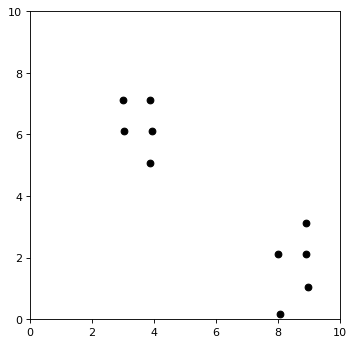

[weighted] An optimal categorisation is [[0, 1, 2, 3, 4], [5, 6, 7, 8, 9]]. There is/are 1 optimal one(s). The optimal codelength is 501.0.
The total encoding of the categorisation [[0, 1, 2, 3, 4], [5, 6, 7, 8, 9]] is of length 501.0.
  This is the result of a compression of 489.0 computed as 500.0 bits for constraints - 11 bits for categories - 0 bits for error correction weighted by the factor 2.
[weighted] An optimal categorisation is [[0, 1, 2, 3, 4], [5, 6, 7, 8, 9]]. There is/are 1 optimal one(s). The optimal codelength is 501.0.
The total encoding of the categorisation [[0, 1, 2, 3, 4], [5, 6, 7, 8, 9]] is of length 501.0.
  This is the result of a compression of 489.0 computed as 500.0 bits for constraints - 11 bits for categories - 0.0 bits for error correction weighted by the factor 1.5.


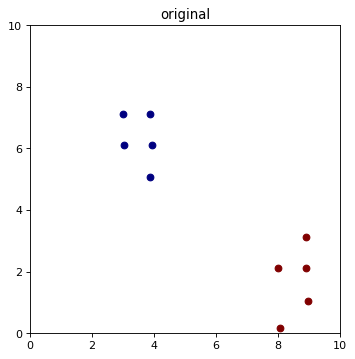

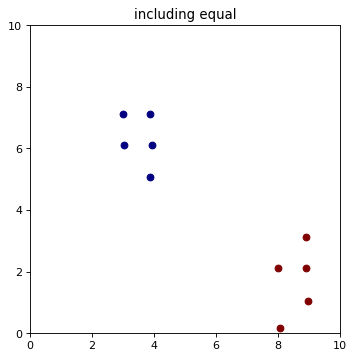

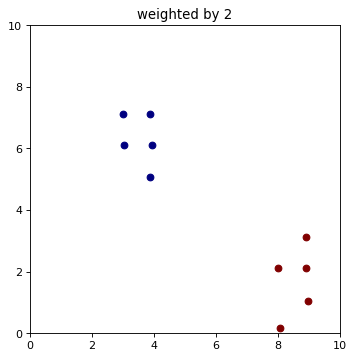

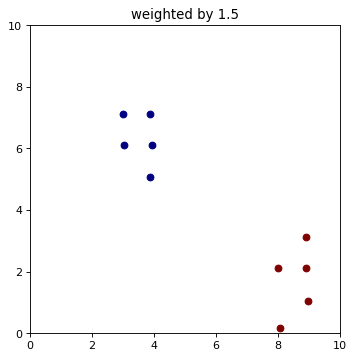

In [14]:
points_1 = np.array([3, 7.13, 3.88, 7.13, 3.02, 6.11, 3.93, 6.11, 3.88, 5.06, 8.91, 3.11, 8.01, 2.13, 8.9, 2.13, 8.98, 1.04, 8.05, 0.18]).reshape(10,2)
plot_points_black(points_1)
do_the_thing(points_1)

### 2) Big, small cluster

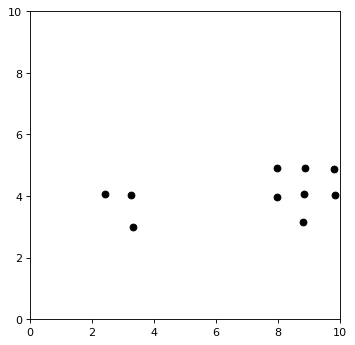

[weighted] An optimal categorisation is [[0, 1, 2], [3, 4, 5, 6, 7, 8, 9]]. There is/are 1 optimal one(s). The optimal codelength is 497.0.
The total encoding of the categorisation [[0, 1, 2], [3, 4, 5, 6, 7, 8, 9]] is of length 497.0.
  This is the result of a compression of 493.0 computed as 504.0 bits for constraints - 11 bits for categories - 0 bits for error correction weighted by the factor 2.
[weighted] An optimal categorisation is [[0, 1, 2], [3, 4, 5, 6, 7, 8, 9]]. There is/are 1 optimal one(s). The optimal codelength is 497.0.
The total encoding of the categorisation [[0, 1, 2], [3, 4, 5, 6, 7, 8, 9]] is of length 497.0.
  This is the result of a compression of 493.0 computed as 504.0 bits for constraints - 11 bits for categories - 0.0 bits for error correction weighted by the factor 1.5.


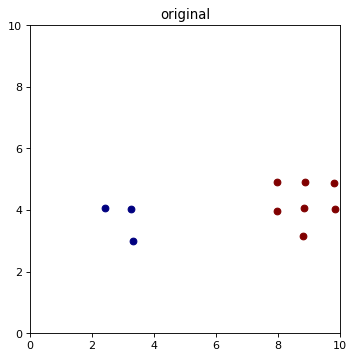

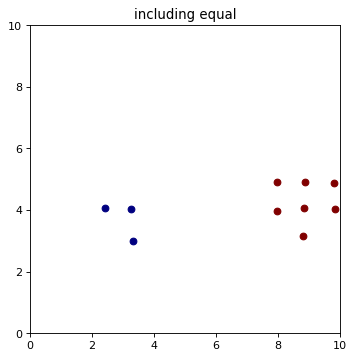

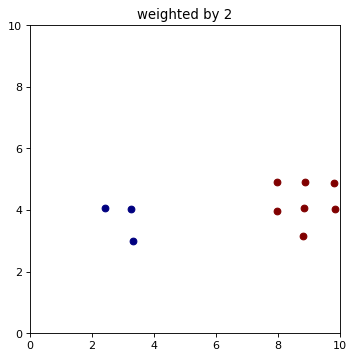

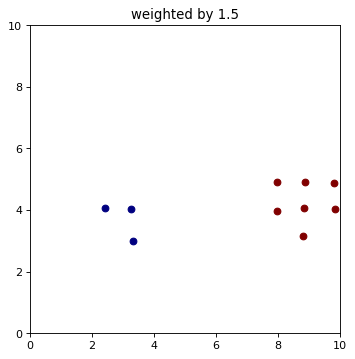

In [15]:
points_2 = np.array([2.42, 4.05, 3.25, 4.02, 3.32, 3.01, 7.96, 4.9, 8.87, 4.9, 9.8, 4.87, 7.97, 3.97, 8.84, 4.07, 9.84, 4.02, 8.81, 3.16]).reshape(10,2)
plot_points_black(points_2)
do_the_thing(points_2)

### 3) Three clusters

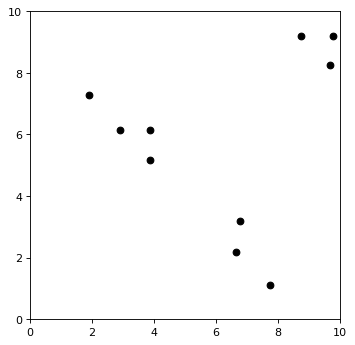

[weighted] An optimal categorisation is [[0, 1, 2, 3], [4, 5, 6], [7, 8, 9]]. There is/are 1 optimal one(s). The optimal codelength is 610.0.
The total encoding of the categorisation [[0, 1, 2, 3], [4, 5, 6], [7, 8, 9]] is of length 610.0.
  This is the result of a compression of 380.0 computed as 396.0 bits for constraints - 16 bits for categories - 0 bits for error correction weighted by the factor 2.
[weighted] An optimal categorisation is [[0, 1, 2, 3], [4, 5, 6], [7, 8, 9]]. There is/are 1 optimal one(s). The optimal codelength is 610.0.
The total encoding of the categorisation [[0, 1, 2, 3], [4, 5, 6], [7, 8, 9]] is of length 610.0.
  This is the result of a compression of 380.0 computed as 396.0 bits for constraints - 16 bits for categories - 0.0 bits for error correction weighted by the factor 1.5.


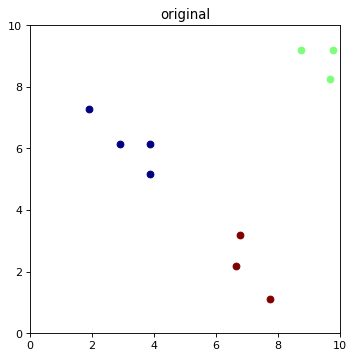

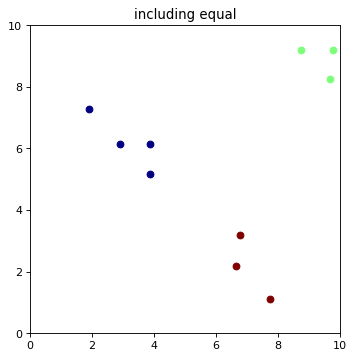

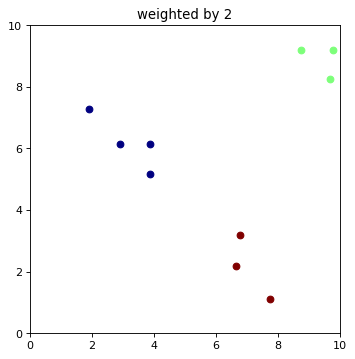

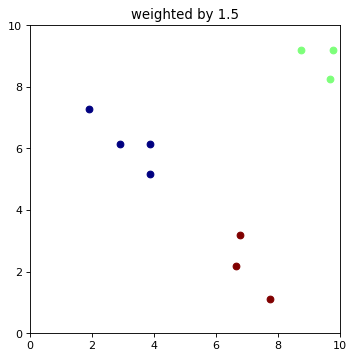

In [16]:
points_3 = np.array([1.91, 7.27, 2.91, 6.15, 3.88, 6.15, 3.88, 5.16, 8.74, 9.2, 9.78, 9.18, 9.69, 8.26, 6.78, 3.18, 6.66, 2.18, 7.75, 1.12]).reshape(10,2)
plot_points_black(points_3)
do_the_thing(points_3)

### 4) Little structure

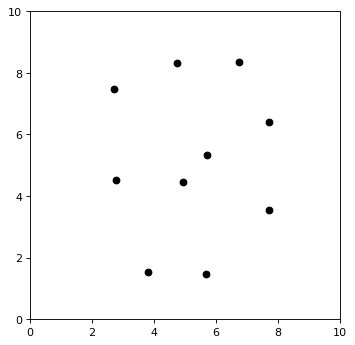

[weighted] An optimal categorisation is [[0], [1, 2], [3], [4, 5], [6], [7], [8, 9]]. There is/are 1 optimal one(s). The optimal codelength is 880.0.
The total encoding of the categorisation [[0], [1, 2], [3], [4, 5], [6], [7], [8, 9]] is of length 880.0.
  This is the result of a compression of 110.0 computed as 126.0 bits for constraints - 16 bits for categories - 0 bits for error correction weighted by the factor 2.
[weighted] An optimal categorisation is [[0, 1], [3, 4, 5], [2, 6], [7], [8, 9]]. There is/are 1 optimal one(s). The optimal codelength is 866.5.
The total encoding of the categorisation [[0, 1], [3, 4, 5], [2, 6], [7], [8, 9]] is of length 866.5.
  This is the result of a compression of 123.5 computed as 234.0 bits for constraints - 19 bits for categories - 91.5 bits for error correction weighted by the factor 1.5.


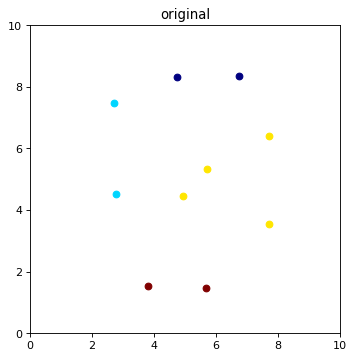

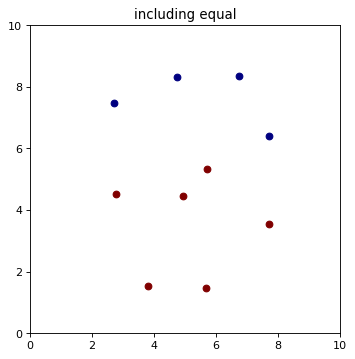

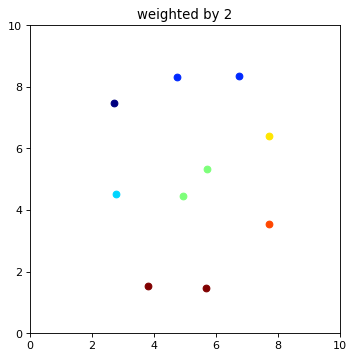

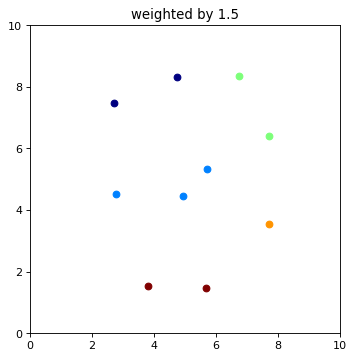

In [17]:
points_4 = np.array([2.7, 7.48, 4.75, 8.32, 6.73, 8.36, 2.77, 4.53, 4.92, 4.45, 5.72, 5.33, 7.72, 6.41, 7.7, 3.53, 3.82, 1.52, 5.69, 1.48]).reshape(10,2)
plot_points_black(points_4)
do_the_thing(points_4)

# Other points used in poster

### 1) Almost a Square

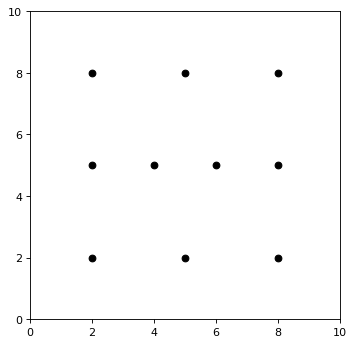

[weighted] An optimal categorisation is [[0], [1, 2], [5], [6, 7], [3, 8], [4, 9]]. There is/are 4 optimal one(s). The optimal codelength is 876.0.
The total encoding of the categorisation [[0], [1, 2], [5], [6, 7], [3, 8], [4, 9]] is of length 876.0.
  This is the result of a compression of 114.0 computed as 164.0 bits for constraints - 18 bits for categories - 32 bits for error correction weighted by the factor 2.
[weighted] An optimal categorisation is [[0], [1, 2], [5], [6, 7], [3, 8], [4, 9]]. There is/are 4 optimal one(s). The optimal codelength is 868.0.
The total encoding of the categorisation [[0], [1, 2], [5], [6, 7], [3, 8], [4, 9]] is of length 868.0.
  This is the result of a compression of 122.0 computed as 164.0 bits for constraints - 18 bits for categories - 24.0 bits for error correction weighted by the factor 1.5.


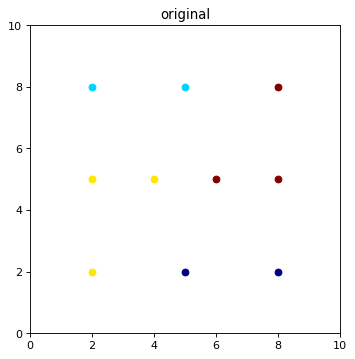

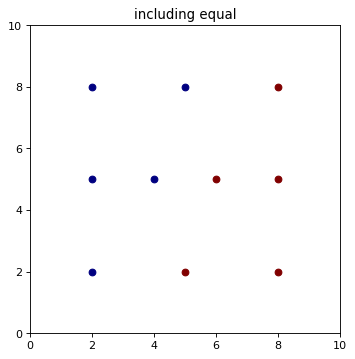

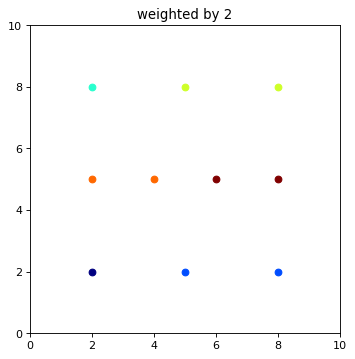

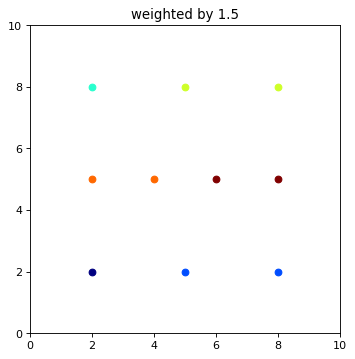

In [18]:
points_square = np.array([2,2,5,2,8,2,2,5,8,5,2,8,5,8,8,8,4,5,6,5]).reshape(10,2)
plot_points_black(points_square)
do_the_thing(points_square)

### 2) Random points

[weighted] An optimal categorisation is [[2, 5], [0, 6], [4, 7], [1, 8], [3, 9]]. There is/are 1 optimal one(s). The optimal codelength is 809.0.
The total encoding of the categorisation [[2, 5], [0, 6], [4, 7], [1, 8], [3, 9]] is of length 809.0.
  This is the result of a compression of 181.0 computed as 200.0 bits for constraints - 19 bits for categories - 0 bits for error correction weighted by the factor 2.
[weighted] An optimal categorisation is [[2, 5], [0, 6], [4, 7], [1, 8], [3, 9]]. There is/are 1 optimal one(s). The optimal codelength is 809.0.
The total encoding of the categorisation [[2, 5], [0, 6], [4, 7], [1, 8], [3, 9]] is of length 809.0.
  This is the result of a compression of 181.0 computed as 200.0 bits for constraints - 19 bits for categories - 0.0 bits for error correction weighted by the factor 1.5.


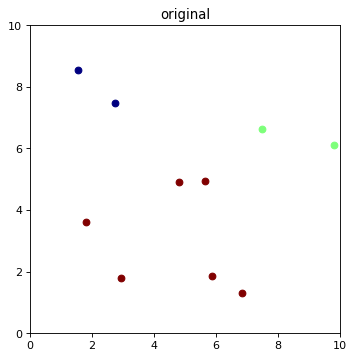

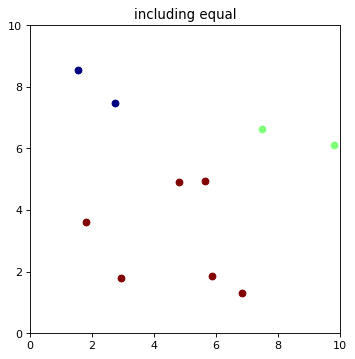

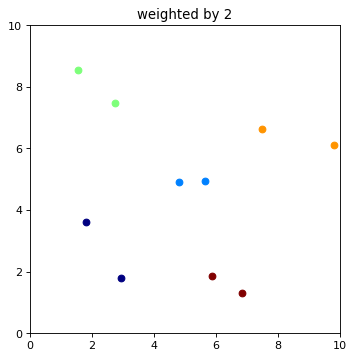

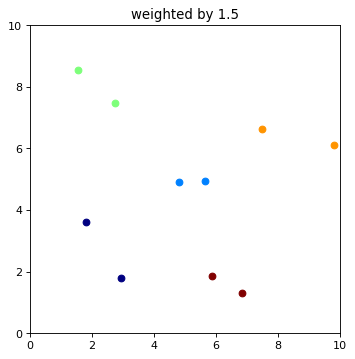

In [19]:
interesting_points = np.array([[0.56373752, 0.4952516 ],
 [0.74737525, 0.66294362],
 [0.29504718, 0.1784774 ],
 [0.68427474, 0.13203215],
 [0.27507492, 0.7465185 ],
 [0.18185629, 0.3598829 ],
 [0.48088529, 0.49016846],
 [0.15374076, 0.85341827],
 [0.98153793, 0.61002606],
 [0.58696527, 0.18632215]]) * 10
plot_points_black(interesting_points)
do_the_thing(interesting_points)